## 4.10 Homework

Use [this notebook](homework-4-starter.ipynb) as a starter

We'll use the credit scoring dataset:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)



## Preparation 

* Execute the preparation code from the starter notebook
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.


Which categorical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt


## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812


## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8


## Quesiton 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7


## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C



## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.



## Nagivation

* [Machine Learning Zoomcamp course](../)
* [Session 4: Evaluation Metrics for Classification](./)
* Previous: [Explore more](09-explore-more.md)

---
# Other resources:
 - [notebook](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/chapter-03-churn-prediction/04-metrics.ipynb)


# My Submission
## Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc as sklearn_auc

In [2]:
## Data

In [3]:
! wget 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

--2021-10-03 21:08:56--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.2’

CreditScoring.csv.2 100%[===================>] 178.21K  --.-KB/s    in 0.002s  

2021-10-03 21:08:56 (82.2 MB/s) - ‘CreditScoring.csv.2’ saved [182489/182489]



In [4]:
df = pd.read_csv('CreditScoring.csv') #[['Seniority', 'Income', 'Assets', 'Records', 'Job', 'Home']]
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


## Preparation
We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [5]:
df.columns = df.columns.str.lower()

# Some of the features are encoded as numbers. Use the following code to de-code them:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}
df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)


# Prepare the numerical variables:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)
#endfor

# Remove clients with unknown default status
df = df[df.status != 'unk'].reset_index(drop=True)

#Create the target variable
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Split code
- Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [6]:
from sklearn.model_selection import train_test_split
y='default'
test=0.2
val=0.2
random_state=1

df_train_full, df_test = train_test_split(df, test_size=test, random_state=random_state)
df_train, df_val = train_test_split(df_train_full, test_size=val/(1-test), random_state=random_state)
y_test = df_test[y].copy().values
y_val = df_val[y].copy().values
y_train = df_train[y].copy().values
del df_test[y]
del df_val[y]
del df_train[y]

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.


Which categorical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

In [7]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [8]:
def get_roc_score(y_pred,y_true,n=101):

    accuracies = []

#     for t in thresholds:
#         acc = accuracy_score(y_val, y_pred >= t)
#         accuracies.append(acc)                  
                  
    scores = []
    for t in np.linspace(0, 1, n): # thresholds
        tp = ((y_pred >= t) & (y_true == 1)).sum()
        fp = ((y_pred >= t) & (y_true == 0)).sum()
        fn = ((y_pred < t) & (y_true == 1)).sum()
        tn = ((y_pred < t) & (y_true == 0)).sum()
        
        scores.append((t, tp, fp, fn, tn))
        
    #endfor
    
    df_scores = pd.DataFrame(scores, columns = ['threshold', 'tp', 'fp', 'fn', 'tn'] )
    
    # sensitivity, recall, hit rate, or true positive rate (TPR)
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn) # True postive rate  => maximize (same as recall)
    #df_scores['recall'] = df_scores['tpr']
    # p = class balance
    #  tp = (t-1) * p 
    #  fv = t * (p-1)
    # TPR = (t-1)*p/ ( 
    
    # fall-out or false positive rate (FPR)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn) # False postive rate => minimize
    
    # accuracy (ACC): 
    # (TP + TN)/(tp + fp + fn + tn)
    df_scores['acc'] = (df_scores.tp + df_scores.tn)/(df_scores.tp + df_scores.tn + df_scores.fp + df_scores.fn)
    
    # precision or positive predictive value (PPV)
    # TP/(TP + FP)
    df_scores['pre'] = df_scores.tp / (df_scores.tp + df_scores.fp)
                  
    # F-Score: # F1 = 2 * P * R / (P + R)
    df_scores['f1'] = 2 * df_scores['tpr'] * df_scores['pre'] / (df_scores['tpr'] + df_scores['pre'])  
                  
    return df_scores
#enddef

def compute_roc(y_pred,y_true,n=101,plot=True,figsize=(20,5)
                ,title=None
                ,seed=1):
    
    # input
    df_scores_pred = get_roc_score(y_pred,y_true,n=n)
        
    # ideal model (binary)
    num_all = len(y_true)
    num_pos = (y_true == 1).sum()
    class_balance = 1 - num_pos/num_all
#     y_ideal_true = np.repeat([0, 1], [num_pos, num_all - num_pos])
    y_ideal_true = np.repeat([0, 1], [num_all - num_pos,num_pos])
    y_ideal_pred = np.linspace(0, 1, num_all)  # ordered prediction by threshold
    df_scores_ideal = get_roc_score(y_ideal_pred,y_ideal_true,n=n)
    
    # Falt (no dependence of feature)
    y_flat_pred = np.repeat(1 - class_balance, num_all)
    df_scores_flat = get_roc_score(y_flat_pred,y_true,n=n)    
    
    # random 
    if True:
    #     np.random.seed(seed)
    #     y_rand = np.random.uniform(0, 1, size=num_all)
    #     df_scores_rand = get_roc_score(y_rand,y_true,n=n)    
    #     df_scores = (df_scores_pred, df_scores_rand,df_scores_ideal)
        t = np.linspace(0, 1, n)
        df_scores_rnd = pd.DataFrame(t, columns = ['threshold'] )
        p = num_pos/num_all
        
        # Mean and STD of the Binomial Distribution: https://en.wikipedia.org/wiki/Binomial_distribution
        # n = Number of elements in subsample
        # p = sucess rate/probability
        bn_stat = lambda n,p: (n*p ,  np.sqrt(n * p * (1-p)) ) # (Mean, STD)
        
        # Error of y=a/(a+b)=1/(1+b/a) => u_y = y^2 sqrt( (u_a * b/a^2)^2 + (u_a * b/a^2)^2 ) _
        e_rate = lambda a,u_a,b,u_b : (1+b/a)**(-2) * np.sqrt( (u_a * b/a**2)**2 + (u_b/a)**2 ) 

        # average number of true postive cases by chance out of subsample (num_all * (t-1))
        TP, TP_std = bn_stat(num_all * (1-t) ,p)
        df_scores_rnd['tp'] = TP
        df_scores_rnd['tp_e'] = TP_std

        # average number of false negative cases by chance out of subsample (num_all * t)
        FN, FN_std = bn_stat(num_all * t ,p)
        df_scores_rnd['fn'] = FN
        df_scores_rnd['fn_e'] = FN_std

        # average number of false postive cases by chance out of subsample (num_all * (t-1))
        FP, FP_std = bn_stat(num_all * (1-t) ,(1-p))
        df_scores_rnd['fp'] = TP
        df_scores_rnd['fp_e'] = TP_std
        
        # average number of false negative cases by chance out of subsample (num_all * t)
        TN, TN_std = bn_stat(num_all * t ,(1-p))
        df_scores_rnd['tn'] = TN
        df_scores_rnd['tn_e'] = TN_std
        
        # sensitivity, recall, hit rate, or true positive rate (TPR): TP/(TP + FN)
        # t=0 => TPR = 1
        # t=1 => TPR = 0
        df_scores_rnd['tpr'] = (1 - t) # [random case]
        df_scores_rnd['tpr_e'] = e_rate(TP,TP_std,FN,FN_std)  #(1 - t)**2 * np.sqrt( (TP_std * FN/TP**2)**2 + (FN_std/TP)**2 ) 
        
        # fall-out or false positive rate (FPR): FP/(FP + TN)
        # t=0 => FPR = 1
        # t=1 => FPR = 0
        df_scores_rnd['fpr'] = 1 - t # [random case]
        df_scores_rnd['fpr_e'] = e_rate(FP,FP_std,TN,TN_std) # (1 - t)**2 * np.sqrt( (FP_std * TN/FP**2)**2 + (TN_std/FP)**2 )  
        
        # accuracy (ACC): (TP + TN)/N = (TP + TN)/(tp + fp + fn + tn)
        # t=0 => acc = p
        # t=1 => acc = 1-p
        df_scores_rnd['acc'] = t * (1-2*p) + p # [random case]
        df_scores_rnd['acc_e'] = np.sqrt( TP_std**2 + TN_std**2 )/num_all
        
        # precision or positive predictive value (PPV): TP/(TP + FP)
        # => independent of "t" 
        df_scores_rnd['pre'] = p # [random case]
        df_scores_rnd['pre_e'] = e_rate(TP,TP_std,FP,FP_std) # p**2 * np.sqrt( (TP_std * FP/TP**2)**2 + (FP_std/TP)**2 ) 
        
        # F-Score: # F1 = 2 * P * R / (P + R)
        df_scores_rnd['f1'] = 2 * (1 - t) * p / ((1 - t) + p)  
        df_scores_rnd['f1_e'] = 0.0 # TODO
        
    #endif

    # summary
    df_scores = (df_scores_pred,df_scores_ideal, df_scores_flat,df_scores_rnd)
        
    if plot:
        colors = ['red','green','blue','gray']
        labels = ['Model','Ideal','Flat','Random']        
        fig, axes = plt.subplots(1,4,figsize=figsize) 
        
        #----------
        # ROC: TPR vs. FPR
        # also see: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
        if True:

            axis = axes[0]
            axis.set_xlabel('False Positive Rate')
            axis.set_ylabel('True Positive Rate')
            axis.set_title(((title and title+': ') or '') + 'ROC curve')
            
            for i, (color, label) in enumerate(zip(colors, labels)):
                auc_value = sklearn_auc(df_scores[i].fpr, df_scores[i].tpr)
                la = label + f' (AUC = {auc_value:.2f})'
                if label == 'Random':
                    axis.plot(df_scores_rnd['fpr'] - df_scores_rnd['fpr_e']
                              ,df_scores_rnd['tpr'] + df_scores_rnd['tpr_e']
                              , color='gray', label=la) #, ls=':')
                    axis.plot(df_scores_rnd['fpr'] + df_scores_rnd['fpr_e']
                              ,df_scores_rnd['tpr'] - df_scores_rnd['tpr_e']
                              , color='gray', label=None) # , ls=':')                    
                else:
                    axis.plot(df_scores[i].fpr, df_scores[i].tpr, color=color, label=la)
                #endif
            #endfor
            


            axis.set_xlim([-0.02, 1.02])
            axis.set_ylim([-0.02, 1.02])
            axis.legend()
        #endif        
        
        #----------
        # TPR/FPR vs. threshold
        if True:
            axis = axes[1]
            axis.set_xlabel('Threshold')
            axis.set_ylabel('Rate')
            axis.set_title(((title and title+': ') or '') + 'TPR/FPR vs. threshold') # + ': TPR/FPR vs. threshold')            
            
            ylimits = [-0.02, 1.02]
            axis.vlines(class_balance, *ylimits ,color='olive', label='class balance',alpha=0.5)
           
            # TPR
            for name, col, ls in zip(['TPR','FPR'],['tpr','fpr'],['--',':']):
                for i, (color, label) in enumerate(zip(colors, labels)):
                    la=f'{name} ({label})'
                    if label == 'Random':
                        axis.plot(df_scores_rnd.threshold, df_scores_rnd[col] + df_scores_rnd[col + '_e']
                                  , color='gray', label=la, ls=ls)            
                        axis.plot(df_scores_rnd.threshold, df_scores_rnd[col] - df_scores_rnd[col + '_e']
                                  , color='gray', label=None, ls=ls)            
                    else:
                        axis.plot(df_scores[i].threshold, df_scores[i][col], color=color, label=la, ls=ls)
                    #endif
                #endfor
            #endfor

            axis.set_xticks(np.linspace(0, 1, 11))
            axis.set_yticks(np.linspace(0, 1, 11))
            axis.set_xlim([-0.02, 1.02])
            axis.set_ylim(ylimits)            
            

            axis.legend()
        #endif
        


        #----------
        # Precision, Recall
        #----------
        for j in [0,1]:
            axis = axes[2+j]
            axis.set_xlabel('Threshold')
            axis.set_ylabel('Metric')
#             axis.set_title(title or 'TPR & FPR')
            if j == 0: axis.set_title(((title and title+': ') or '') + 'Precision & Recall')
            if j == 1: axis.set_title(((title and title+': ') or '') + 'Accurcay & F-Score')
           
            limits = [-0.02, 1.02]
            color='olive'
            axis.vlines(class_balance, *limits,color=color, label='class balance', ls='-',alpha=0.5)
            axis.hlines(class_balance, *limits,color=color, label=None, ls='-',alpha=0.5)
            axis.hlines(1-class_balance, *limits,color=color, label=None, ls='-',alpha=0.5)
            
            if j == 0: loop = zip(['Precision','Recall'],['pre','tpr'],[':','--'])
            if j == 1: loop = zip(['Accuracy','F-Score'],['acc','f1'],[':','--'])
            
            for name, col, ls in loop:
                for i, (color, label) in enumerate(zip(colors, labels)):
#                     la=f'{name} ({label})' if i == 0 else None
                    la=name if i == 0 else None
                    if label == 'Random':
                        axis.plot(df_scores[i]['threshold'], df_scores_rnd[col] + df_scores_rnd[col + '_e']
                                  , color='gray', label=la, ls=ls)            
                        axis.plot(df_scores[i]['threshold'], df_scores_rnd[col] - df_scores_rnd[col + '_e']
                                  , color='gray', label=None, ls=ls)            
                    else:
                        axis.plot(df_scores[i]['threshold'], df_scores[i][col], color=color, label=la, ls=ls)
                    #endif                    
                #endfor        
            #endfor      
            
            
            axis.set_xticks(np.linspace(0, 1, 11))
            axis.set_yticks(np.linspace(0, 1, 11))
            axis.set_xlim(limits)
            axis.set_ylim(limits)
#             axis.grid()
            loc = 'lower left' if class_balance > 0.5 else'upper right'
            axis.legend(loc=loc,framealpha=0.3)
        #endif        
            

        plt.tight_layout()
        # plt.savefig('04_fpr_tpr_plot.svg')
        plt.show() 
    #endif
    
    return df_scores
#enddef

In [9]:
model = LogisticRegression(solver='liblinear', C=1.0, random_state=42)
X = df_train[['seniority', 'time', 'age',  'expenses', 'income', 'assets', 'debt', 'amount', 'price']]
model.fit(X, y_train)
y_pred = model.predict_proba(X)[:, 1]

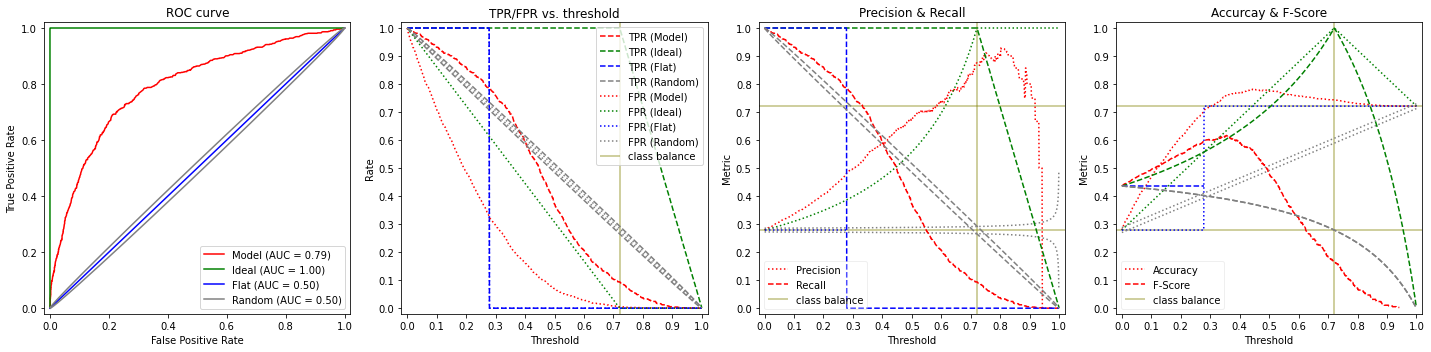

In [10]:
df_scores = compute_roc(y_pred,y_train,title=None,n=1001)

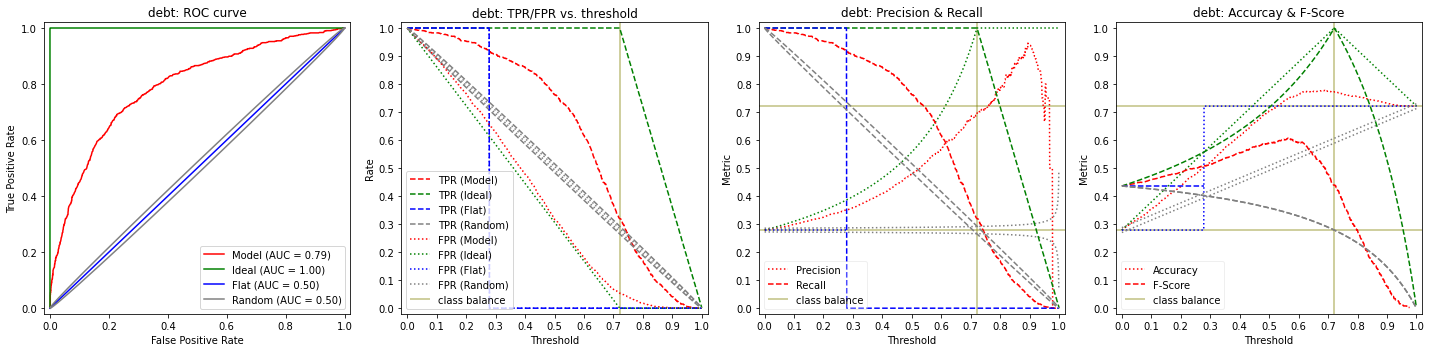

In [11]:
# Importance of balancing classes !
# shift its more to ideal case
model = LogisticRegression(solver='liblinear', C=1.0, random_state=42 ,class_weight='balanced')
X = df_train[['seniority', 'time', 'age',  'expenses', 'income', 'assets', 'debt', 'amount', 'price']]
model.fit(X, y_train)
y_pred = model.predict_proba(X)[:, 1]
df_scores = compute_roc(y_pred,y_train,title=c,n=1001)

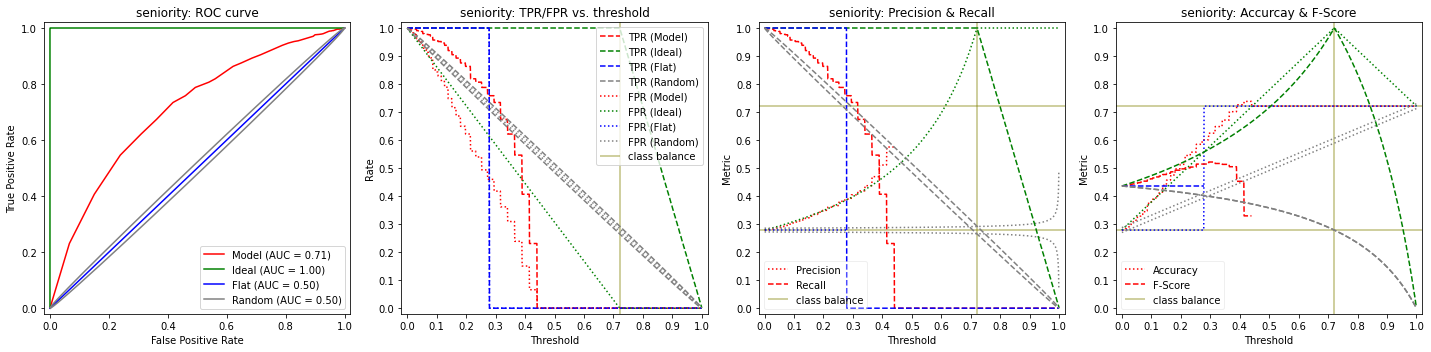

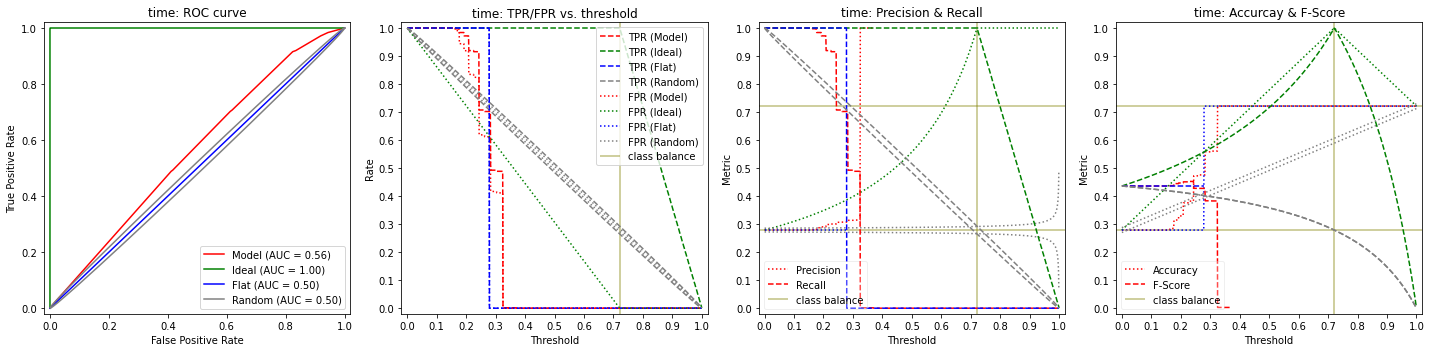

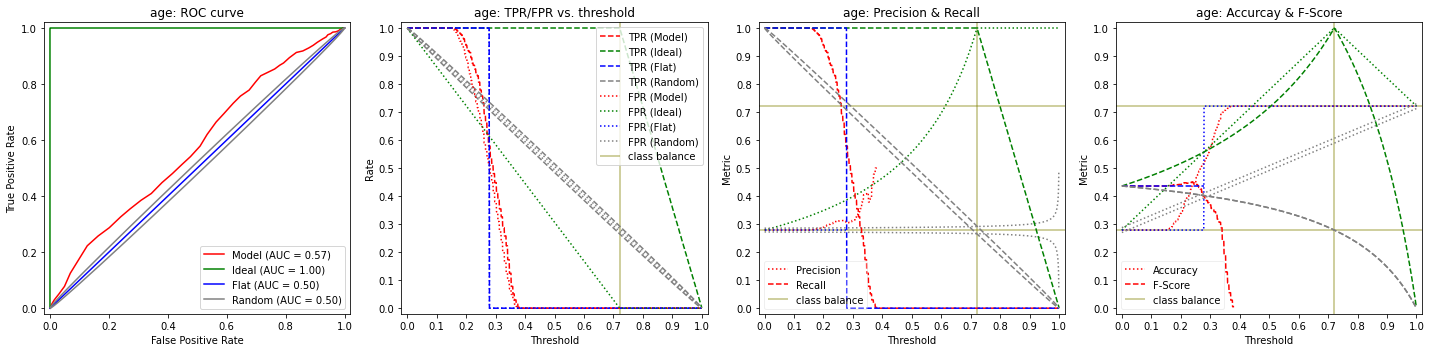

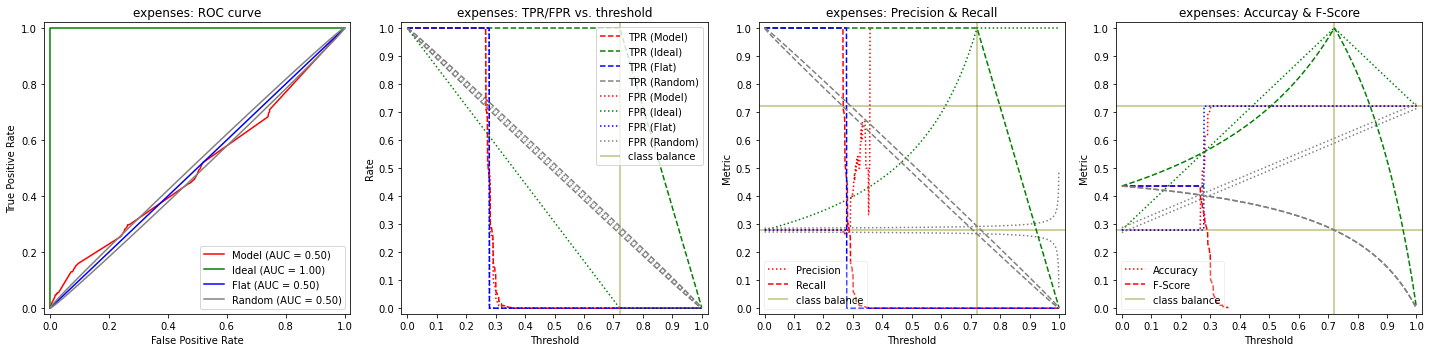

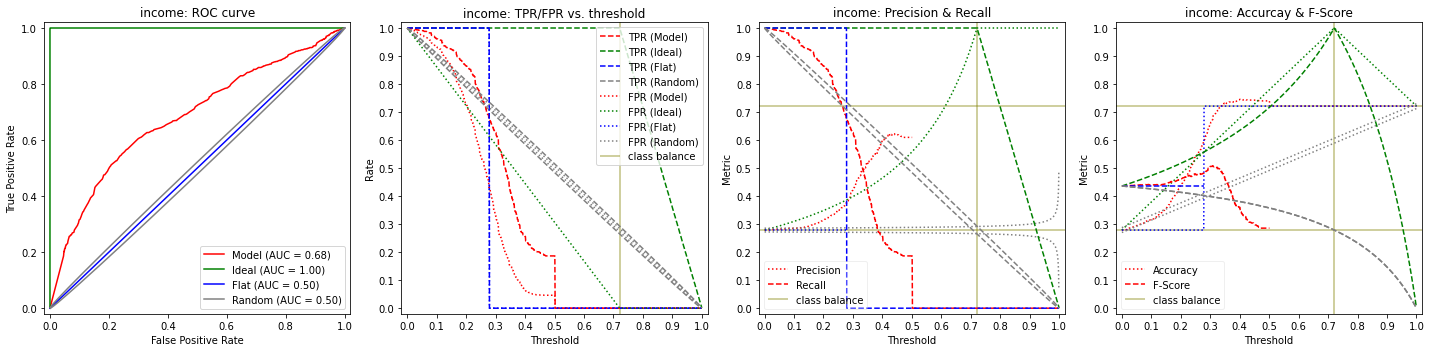

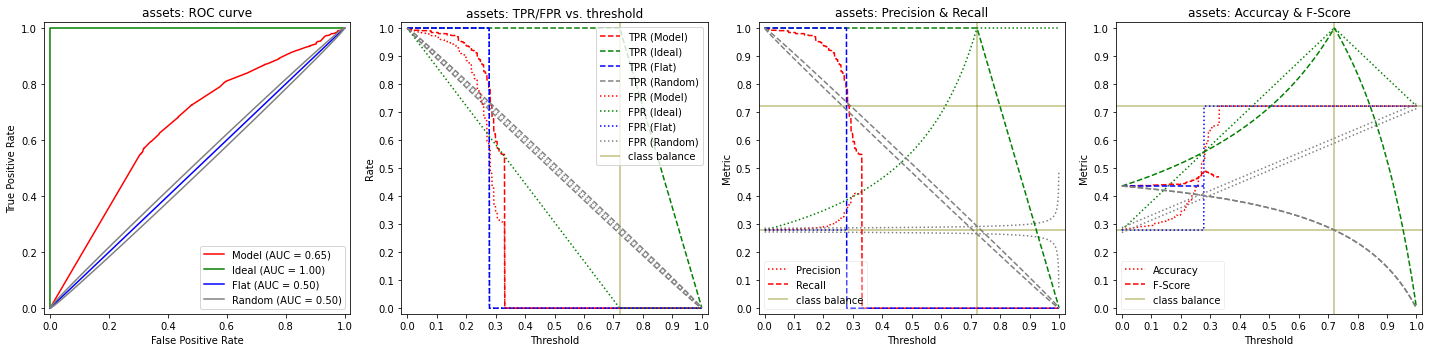

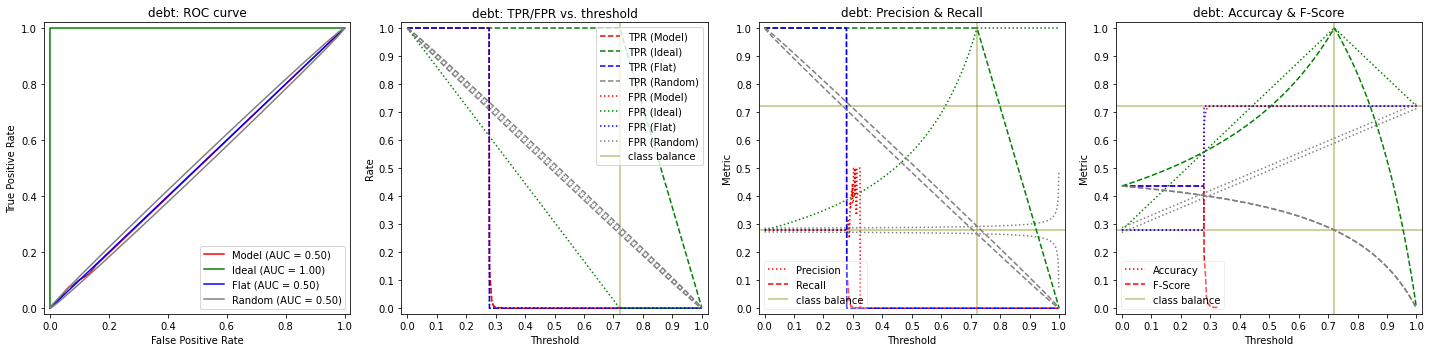

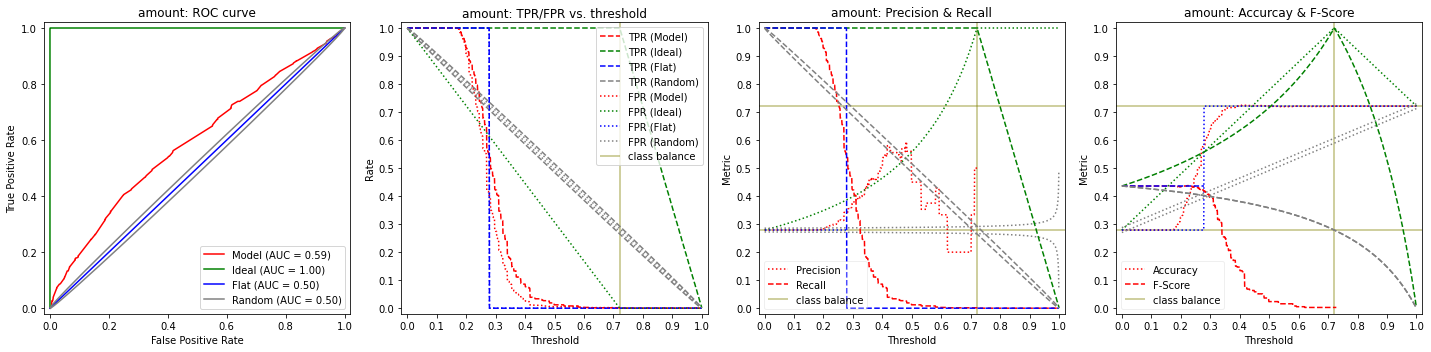

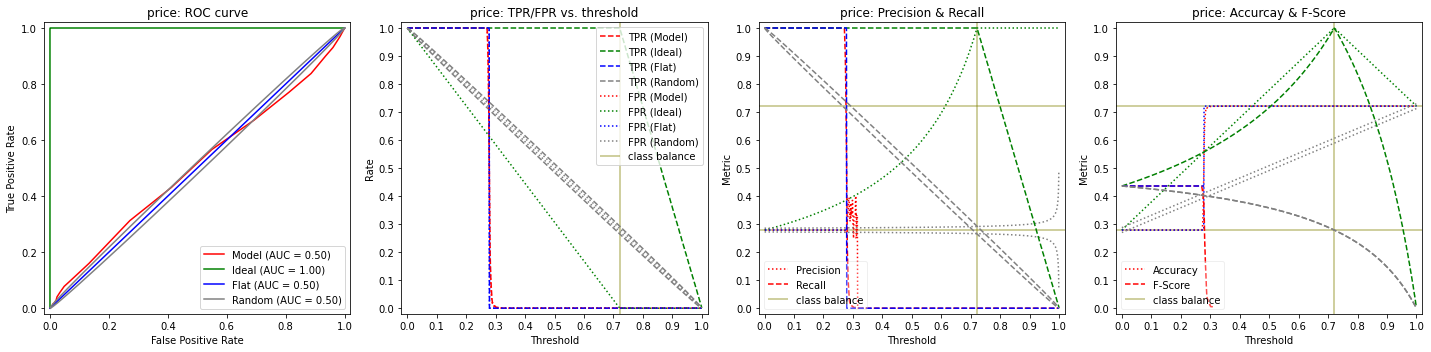

[0.7093778624491943, 0.5608662489595051, 0.5732933272499938, 0.49827669674669045, 0.6820000487595907, 0.6484450914764752, 0.4987238918512275, 0.5910560979092584, 0.5035820885125887]


In [12]:
# for sinlg features
model = LogisticRegression(solver='liblinear', C=1.0, random_state=42)
auc_list = []
f_list = ['seniority', 'time', 'age',  'expenses', 'income', 'assets', 'debt', 'amount', 'price']
for c in f_list:
# for c in ['seniority']:
# for c in ['debt']:
    X = (-df_train[c]).to_frame()
    model.fit(X, y_train)
    y_pred = model.predict_proba(X)[:, 1]
    df_scores = compute_roc(y_pred,y_train,title=c,n=1001)
    auc_list.append( sklearn_auc(df_scores[0].fpr, df_scores[0].tpr))
#endfor
pd.Series(dict(zip(f_list,auc_list))).sort_values(ascending=False).to_frame()
print(auc_list)

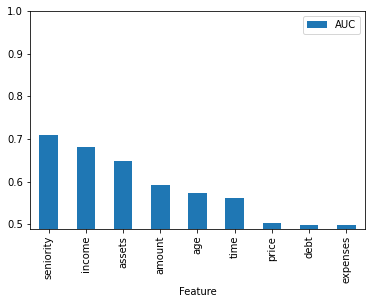

In [13]:
df_auc = pd.Series(dict(zip(f_list,auc_list))).sort_values(ascending=False).to_frame(name='AUC').rename_axis('Feature')
df_auc.plot(kind='bar')
plt.ylim(0.49,1.0)
plt.show()

In [14]:
print('Which categorical variable (among the following 4) has the highest AUC? :\t'
    ,df_auc.loc[['seniority', 'time', 'income', 'debt']].sort_values('AUC',ascending=False).index[0]
     )

Which categorical variable (among the following 4) has the highest AUC? :	 seniority


## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [15]:
df01 = df[['seniority', 'income', 'assets', 'records', 'job', 'home','default']]
df01.head()

,seniority,income,assets,records,job,home,default
0,9,129,0,no,freelance,rent,0
1,17,131,0,no,fixed,rent,0
2,10,200,3000,yes,freelance,owner,1
3,0,182,2500,no,fixed,rent,0
4,0,107,0,no,fixed,rent,0


In [16]:
from sklearn.model_selection import train_test_split
y='default'
test=0.2
val=0.2
random_state=1

df_train_full, df_test = train_test_split(df01, test_size=test, random_state=random_state)
df_train, df_val = train_test_split(df_train_full, test_size=val/(1-test), random_state=random_state)
y_test = df_test[y].copy().values
y_val = df_val[y].copy().values
y_train = df_train[y].copy().values
del df_test[y]
del df_val[y]
del df_train[y]

In [17]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
dv.fit(df_train.to_dict(orient='records'))

x_op = lambda x : dv.transform(x.to_dict(orient='records'))
X_train = x_op(df_train)
X_val = x_op(df_val)
X_test = x_op(df_test)

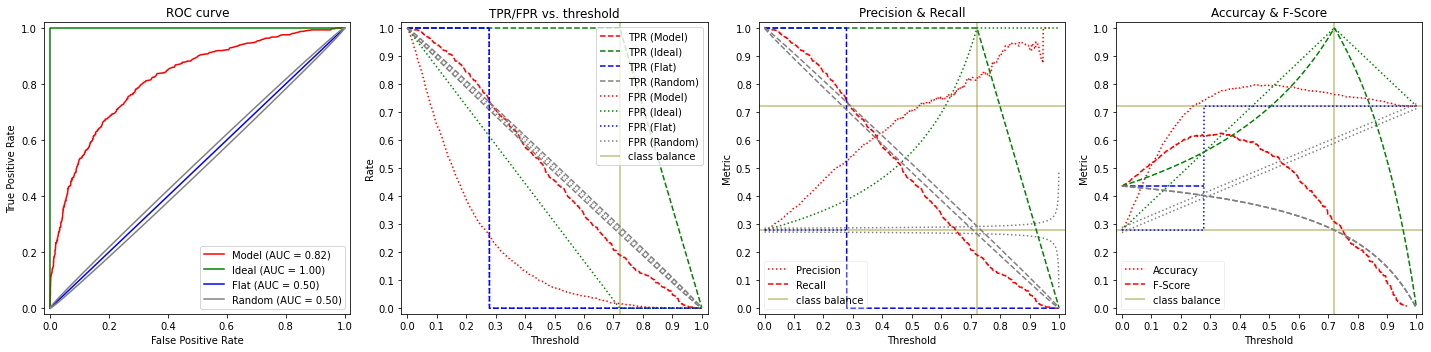

In [18]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_train)[:, 1]
df_scores = compute_roc(y_pred,y_train,n=1001)

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

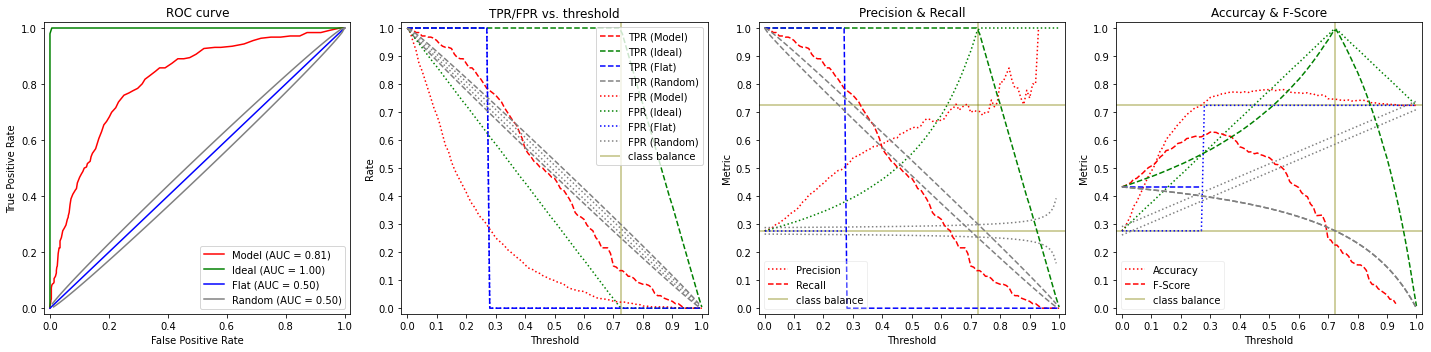

In [19]:
df_scores_val = compute_roc(model.predict_proba(X_val)[:, 1] ,y_val ,n=101)

In [20]:
print("What's the AUC of this model on the validation dataset? (round to 3 digits):\t", 
 round(sklearn_auc(df_scores_val[0].fpr, df_scores_val[0].tpr),3))

What's the AUC of this model on the validation dataset? (round to 3 digits):	 0.812


## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

In [21]:
x = df_scores_val[0]['threshold'].values
y1 = df_scores_val[0]['pre'].values
y2 = df_scores_val[0]['tpr'].values
# Following: https://stackoverflow.com/questions/28766692/intersection-of-two-graphs-in-python-find-the-x-value
#  First it calculates f - g and the corresponding signs using np.sign. 
#  Applying np.diff reveals all the positions, where the sign changes (e.g. the lines cross). 
#  Using np.argwhere gives us the exact indices.
idx = np.argwhere(np.diff(np.sign(y1 - y2))).flatten()
print(f'At which threshold precision and recall curves intersect?:\t threshold = {x[idx[0]]:.1f}')

At which threshold precision and recall curves intersect?:	 threshold = 0.4


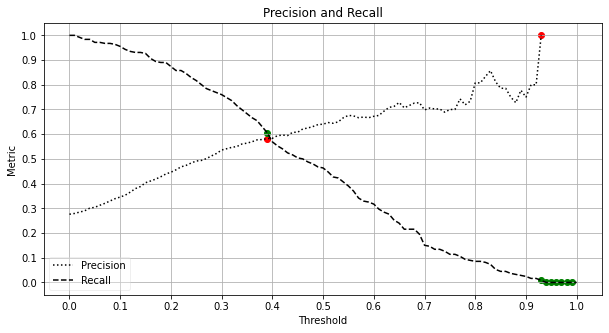

In [22]:
fig, axis = plt.subplots(figsize=(10,5)) 
axis.set_xlabel('Threshold')
axis.set_ylabel('Metric')
axis.set_title('Precision and Recall')
for name, col, ls in zip(['Precision','Recall'],['pre','tpr'],[':','--']):
    axis.plot(df_scores_val[0]['threshold'], df_scores_val[0][col], color='k', label=name, ls=ls)   
#endfor

# show intersection point(s)
plt.scatter(x[idx], y1[idx],color='r')
plt.scatter(x[idx], y2[idx],color='g')

axis.set_xticks(np.linspace(0, 1, 11))
axis.set_yticks(np.linspace(0, 1, 11))
axis.legend(framealpha=0.3)
axis.grid()
plt.show() 

## Quesiton 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

In [23]:
recall = df_scores_val[0]['tpr']
prec =  df_scores_val[0]['pre']
f_score = 2 * recall * prec / (recall + prec) # F1 = 2 * P * R / (P + R)
idxmax = f_score.idxmax()
print('At which threshold F1 is maximal?:\t threshold ='
    ,df_scores_val[0]['threshold'][idxmax]
     )

At which threshold F1 is maximal?:	 threshold = 0.3


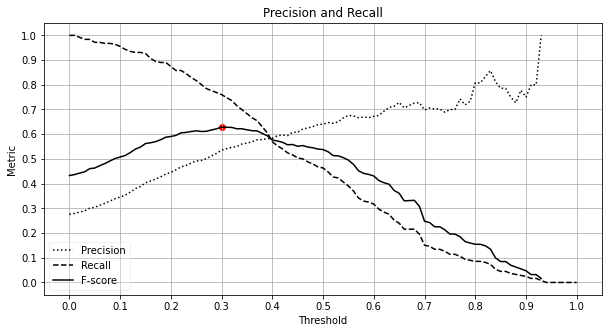

In [24]:
fig, axis = plt.subplots(figsize=(10,5)) 
axis.set_xlabel('Threshold')
axis.set_ylabel('Metric')
axis.set_title('Precision and Recall')
# df_scores_val[0]['f1'] = f_score
for name, col, ls in zip(['Precision','Recall','F-score'],['pre','tpr','f1'],[':','--','-']):
    axis.plot(df_scores_val[0]['threshold'], df_scores_val[0][col], color='k', label=name, ls=ls)   
#endfor

# show max point 
plt.scatter(df_scores_val[0]['threshold'][idxmax], f_score[idxmax],color='r')

axis.set_xticks(np.linspace(0, 1, 11))
axis.set_yticks(np.linspace(0, 1, 11))
axis.legend(framealpha=0.3)
axis.grid()
plt.show() 

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

In [33]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

dv = DictVectorizer(sparse=False)

auc_list = []
for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    
    dv.fit(df_train.drop(y,axis=1).to_dict(orient='records'))

    x_op = lambda x : dv.transform(x.drop(y,axis=1).to_dict(orient='records'))
    X_train = x_op(df_train)
    X_val = x_op(df_val)
    
    y_train = df_train[y].values
    y_val = df_val[y].values
    
    model.fit(X_train, y_train)
    
    y_pred_val = model.predict_proba(X_val)[:, 1]
    df_scores_val = get_roc_score(y_pred_val,y_val)
    auc_list.append( sklearn_auc(df_scores_val['fpr'], df_scores_val['tpr'] ) )
#endfor

print(f'How large is standard devidation of the scores across different folds?:\t {np.std(auc_list):.2g}')



How large is standard devidation of the scores across different folds?:	 0.014


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [41]:
auc_mean = {}
for C in [0.01, 0.1, 1, 10]:
    auc_list = []
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        dv.fit(df_train.drop(y,axis=1).to_dict(orient='records'))

        x_op = lambda x : dv.transform(x.drop(y,axis=1).to_dict(orient='records'))
        X_train = x_op(df_train)
        X_val = x_op(df_val)

        y_train = df_train[y].values
        y_val = df_val[y].values

        model.fit(X_train, y_train)

        y_pred_val = model.predict_proba(X_val)[:, 1]
        df_scores_val = get_roc_score(y_pred_val,y_val)
        auc_list.append( sklearn_auc(df_scores_val['fpr'], df_scores_val['tpr'] ) )
    #endfor
    auc_mean[C] = np.mean(auc_list)
    print('C=%4s, auc = %0.3f ± %0.3f' % (C, np.mean(auc_list), np.std(auc_list)))
#endfor

print(f'Which C leads to the best mean score?:\t{max(auc_mean, key=auc_mean.get)}')

C=0.01, auc = 0.808 ± 0.013
C= 0.1, auc = 0.813 ± 0.014
C=   1, auc = 0.812 ± 0.014
C=  10, auc = 0.814 ± 0.015
Which C leads to the best mean score?:	10
